In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import regex
import os, sys
import scipy.stats as spyss
import matplotlib.pyplot as plt
import collections

# USER INPUTS

In [2]:
"""Experiment name to prepend output files"""
EXPERIMENT = "mouse_sample"

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
FILTERED_FILEPATH = "../output/filtered-mouse_sample.csv"

"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100

### CONCLUSIONS FROM MOUSE DATA
##### 2016-10-25 VWL

Rewrote and fixed rolling window function and implemented variable window size and step (or shift) lengths. Although I have not compared the previous strategy (fixed window size 2, step of 1) directly with the new window size, results do look promising and ID thresholds in logical positions. (Need to compare to biological data)

Next steps:  clean up code, test different windows.

I would like to make the window selection not so influenced by users; ideally, selecting window size and steps based on the curvature of the initial data, i.e. how linear it is (when comparing rank to logged abundance). 

As per the smith/Simulating_umi_deduping.ipynb script, I would like to merge this with the graph approach. The graph approach gets rid of the arbitrary rank system and would facilitate adjustments based on sequence content (e.g. G's are more commonly erroneously sequenced than T's). I'd keep this thresholding model; need to figure out how to merge.....

# PRESETS AND SCRIPT

In [3]:
"""Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']

# for older versions/ formats
# SAMPLE = 'idx'
# QTAG = 'qtag'
# BARCODE = 'gtag'
# READS = 'reads'
# MCOUNTS = 'molecs'
# PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
# GROUPBY = ['idx']

In [4]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [5]:
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS):
    """Updates percent molec counters for sample"""
    total = float(df[mcounts].values.sum()) / 100.
    df[percent_mcounts] = df[mcounts].apply(lambda x: x/total)
    df = df.sort_values(by=mcounts, ascending=False)
    return df

In [6]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    csv = pd.read_csv(filtered_file)
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [7]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [8]:
def threshold(group, reps_remaining, thresh_val, thresh_i,
             percent_mcounts=PERCENT_MCOUNTS, mcounts=MCOUNTS, win_size=2, win_shift=1):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging [0,len(group))

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        # calculate new threshold 
        
        # line add 2016-10-12 to pre-sort values
#         print group.head()
#         print mcounts
#         print win_size, win_shift
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        # existing
        group = calculate_percent_molecs(group)
        calc_threshold_i = calculate_threshold(group[mcounts].values,  win_size=win_size, win_shift=win_shift)
        new_thresh_i = min(calc_threshold_i, len(group)-1)
        new_thresh_val = group[percent_mcounts].values[new_thresh_i]
#         print "\nTOP OF THRESHOLD "
#         print 'group len', len(group)
#         print 'thresh_val', thresh_val
#         print 'thresh_i', thresh_i
#         print 'calc_threshold_i', calc_threshold_i
#         print 'new_thresh_i', new_thresh_i
#         print 'new_thresh_val',new_thresh_val, '\n'
        
        # if reached steady state
        if new_thresh_val == thresh_val:
            # get rid of any "padding" barcodes (see eliminate_oneoffs fn)
            # line added 2016-10-12 to remove barcodes that didn't pass threshold
            passed_temp = group.loc[(group.is_padding==False) & (group[percent_mcounts]>=new_thresh_val)]
            
            passed = calculate_percent_molecs(passed_temp)
            # update percent molecs
            passed.reset_index(inplace=True,drop=True)
#             print 'barcodes', len(group)
            sys.stdout.write('Thresholded.\n')
                       
            return passed
        # recursively clean and re-threshold
        else:
            # clean up group by eliminating one-offs
            
            group = calculate_percent_molecs(group)
            cleaned = eliminate_oneoffs(group,new_thresh_val)
            cleaned.reset_index(inplace=True,drop=True)
            # recurse with cleaned df and new threshold values
            return threshold(cleaned, reps_remaining-1, new_thresh_val, 
                             new_thresh_i, percent_mcounts=percent_mcounts, 
                             mcounts=mcounts,  win_size=win_size, win_shift=win_shift)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [66]:
# STEP 2: CALCULATE THRESHOLD via. CONCAVITY


def calculate_threshold(y, win_size, win_shift):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window_ints(arr, win_size=win_size, win_shift=win_shift):
        right = win_size
        windows = []
        while right <= len(arr):
            left = right-win_size
            w = arr[left:right]
            windows.append(w)
            right += win_shift
        if right-win_shift < len(arr):
            windows.append(arr[len(arr)-win_size: len(arr)])
        return windows

    def first_d_gen(windows):
        
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
            q1 = max(win_size/4, 1)
            q3 = win_size-q1
            left = np.mean(w[:q1])
            right = np.mean(w[q3:])
            yield float(right-left)/np.mean(w)
            
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield w[1]-w[0]         
    
    y_temp = sorted(y, reverse=True)
    
#     if False in [yi==y_tempi for yi, y_tempi in zip(y, y_temp)]:
#         print "DIFFERENT!"
    # left and right padding to cover all array vals in derivations
    yarray = np.concatenate([ [y_temp[0]], y_temp, [1] ])
    # calculates first derivative
    
    if len(y_temp) < 25:
         win_size1, win_shift1 = 2, 1
    else: win_size1, win_shift1 = win_size, win_shift
    first_windows = rolling_window_ints(yarray, win_size = win_size1, win_shift=win_shift1)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    # calculates second derivative
    if len(first_derivs) < 6:
        win_size2, win_shift2 = 2, 1
    else: win_size2, win_shift2 = win_size, win_shift

    second_windows = rolling_window_ints(first_derivs, win_size = win_size2, win_shift=win_shift2)
    second_derivs = np.fromiter(first_d_gen(second_windows), np.float
                                , count=len(second_windows))
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    # for second deriv
    thresh_i = (np.argmin(second_derivs)+1)*win_size1*win_size2
    
#     print "\nCALCULATE THRESHOLD"
#     print "2nd max", np.argmax(second_derivs), np.max(second_derivs)
#     print "2nd min", np.argmin(second_derivs), np.min(second_derivs)
#     print "\n"
    return thresh_i

In [10]:
def eliminate_oneoffs(group, thresh_val, pad=True,
                      qtag=QTAG, barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS, 
                      mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
    """
    group.loc[:,'delete'] = group[mcounts].apply(lambda _: False)
    group.loc[:,'is_padding'] = group[mcounts].apply(lambda _: False)
    counter = 0
    # add capability to check other parameters, i.e. qtag
    for majorI, majorRow in group.loc[group[percent_mcounts] > thresh_val].iterrows():
        # if it has not yet been tested
        if majorRow.delete == False:
            subgroup = group[counter+1:].loc[(group.delete==False)]
            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for minorI, minorRow in subgroup.iterrows():
                query = regex.search("(%s){s<=1}" % majorRow[barcode],
                                     minorRow[barcode])
                if query:
                    group.loc[minorI,'delete'] = True
        counter+=1
        
    # select barcodes which pass, ie. are not eliminated
    output = group.loc[(group.delete==False) & (group[percent_mcounts] >= thresh_val)]
#     print "\nEND OF ELIMINATE ONEOFFS"
#     print len(output)
    # if requested, adds a right pad  
    # line added 2016-10-12: combine two conditions: ensure that 
    # no null rows get added if all barcodes are accepted
    if pad==True and len(group) != len(group.delete==False):
        deletes = group.loc[(group.delete==True) & (group[percent_mcounts]<thresh_val)][mcounts]
#         if len(deletes) > 0:
        max_i = deletes.idxmax()
        output.append(group.loc[max_i,:])
        output.loc[max_i,['delete', 'is_padding']] = [False, True]
#     print output.head(), "\n"
    return output
            

In [11]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS, percent_mcounts=PERCENT_MCOUNTS,
                  min_reads=MIN_READS, min_mcount=50, win_size=2, win_shift=1):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
#         print '\n\n>>>>> NEW INDEX'
        sys.stdout.write("Sample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        group = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') 
                          & (group[mcounts] > min_mcount)
                          & (group[reads] > min_reads)]
        result = threshold(group, 20, -1, len(group)+2, win_size=win_size, win_shift=win_shift)
        passed.append(result)
        sys.stdout.flush()
        counter += 1
    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        # formatting
        passeddf.sort_values(by=[sample,percent_mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.drop(['delete','is_padding'], axis=1, inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        return passeddf
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [12]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [13]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [31]:
def apply_passed_data(filtered, passed, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row[percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row['passed_threshold'] = True
        return row

    passed_indexed = passed.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered['passed_threshold'] = False
    filtered[percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

In [67]:
if __name__=='__main__':
    # Check all inputs exist and are valid
    check_inputs()
    # Runs data loading in script
    filtered = load_data(FILTERED_FILEPATH)
    # Run thresholding of all samples in dataset
    passed = run_threshold(filtered,  win_size=5, win_shift=2)
    save_data(filtered, passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT)

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Sample 1 of 26 (CS-V11): 

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Thresholded.
Sample 2 of 26 (CS-V12): No barcodes passed threshold. Skipping sample.
Skipped.
Sample 3 of 26 (CS-V20): Thresholded.
Sample 4 of 26 (CS-V24): Thresholded.
Sample 5 of 26 (CS-V25): Thresholded.
Sample 6 of 26 (CS-V26): Thresholded.
Sample 7 of 26 (CS-V27): 

KeyboardInterrupt: 

In [ ]:
counts = passed.groupby('idx').apply(len)
pass_v_above = {}
filtered = apply_passed_data(pd.concat([f[1] for f in filtered]), passed)
groups = filtered.groupby('idx')

In [ ]:
for idx, pc in counts.iteritems():
    last = passed.loc[passed.idx==idx][pc-1:pc]
    idx_series = groups.get_group(idx).sort_values(by='mcountsPF',ascending=False)
    y = idx_series.mcountsPF.values
    x = range(len(y))

    above_thresh = idx_series.loc[(idx_series.mcountsPF>=last.mcountsPF.values[0])]
    plot_thresh = len(above_thresh)
    c = plot_thresh
    f, ax = plt.subplots()
    ax.plot(x, np.log10(y), label=idx)
    ax.plot([pc,pc],np.log10([1,max(y)] ), label=str(pc)+ "passed")
    ax.plot([c,c],np.log10([1,max(y)] ), label=str(c)+ "above t")
    ax.legend()
    pass_v_above[idx] = [pc,c]

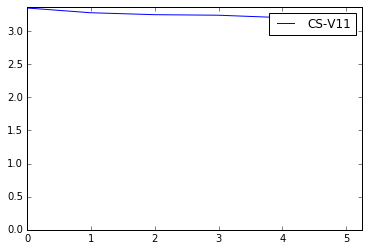

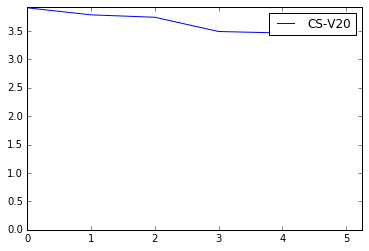

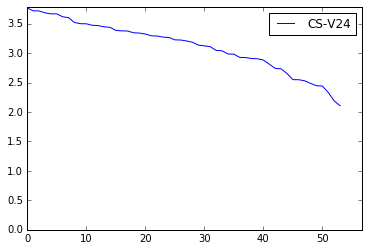

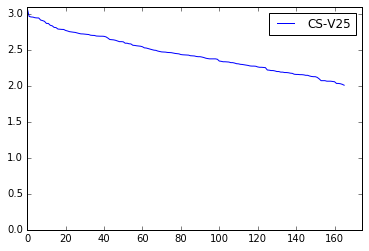

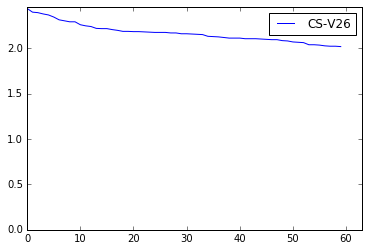

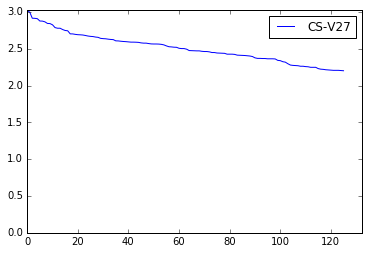

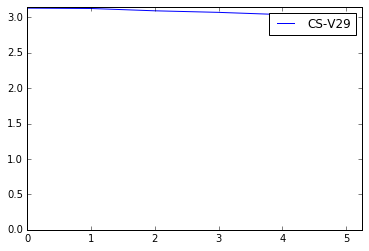

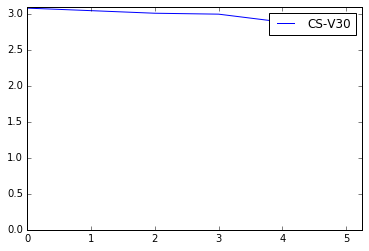

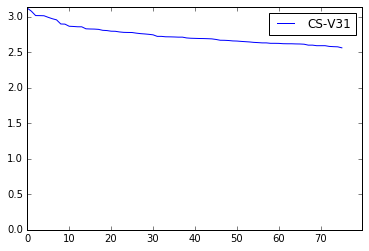

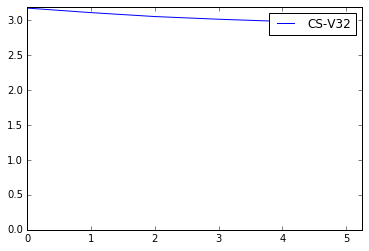

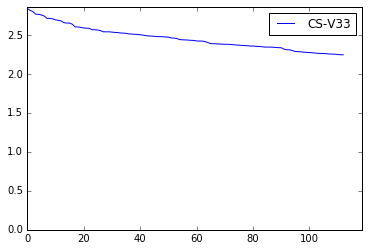

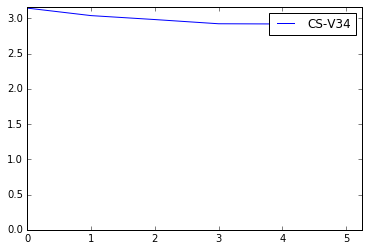

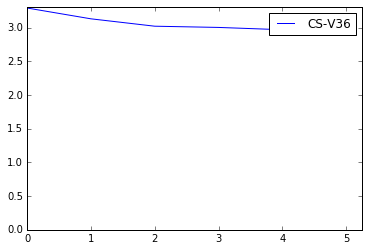

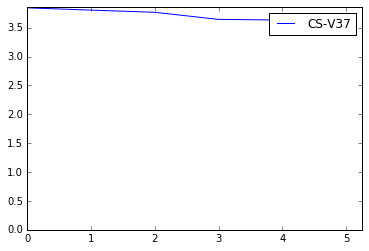

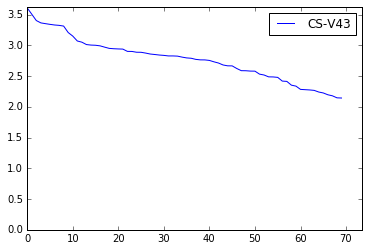

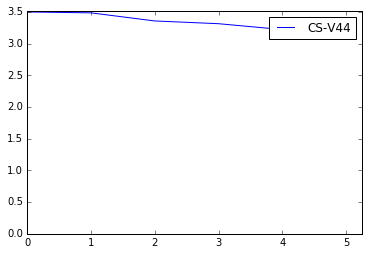

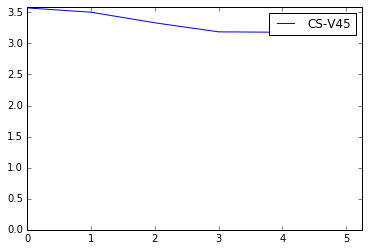

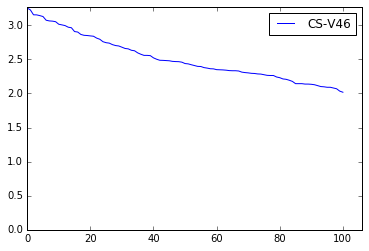

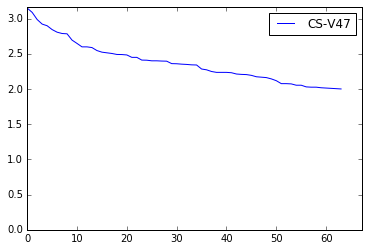

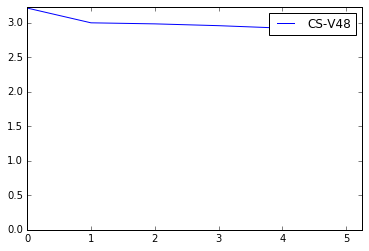

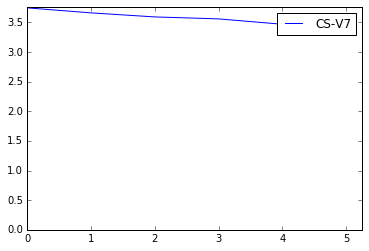

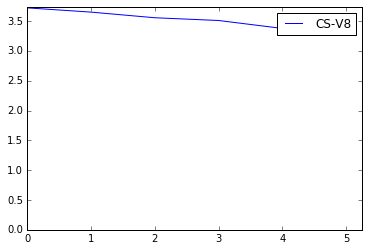

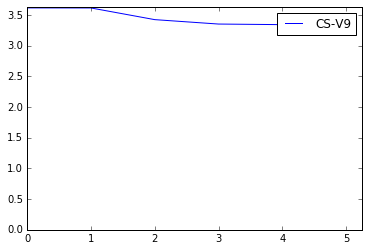

In [65]:
for idx, passdf in passed.groupby('idx'):
    f, ax = plt.subplots()
    y = passdf.sort_values(by='mcountsPF',ascending=False).mcountsPF.values
    ax.plot(range(len(passdf)), np.log10(y), label=idx)
    ax.legend()
    ax.set_ylim(np.log10([1, max(y)*1.05]))
    ax.set_xlim([0,len(passdf)*1.05])